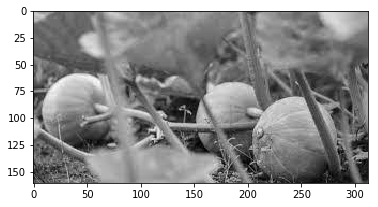

In [23]:
#IMPORT DES DEPENDANCES

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/home/ed/deeplearning/legumesimages"

CATEGORIES = ["Courges", "Haricots", "Mais"] # créer 3 catégories de légumes

for category in CATEGORIES: 
    path = os.path.join(DATADIR,category)  # créer un chemin vers les categories
    for img in os.listdir(path):  # itérer sur chaque image 

        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convertir en tableau 
        plt.imshow(img_array, cmap='gray')  # passage en noir et blanc
        plt.show()  # affichage!

        break  # nous en voulons juste un pour le moment, alors pause 
    break 


In [24]:
print(img_array)

[[183 178 169 ... 155 155 161]
 [188 184 177 ... 156 156 159]
 [195 193 190 ... 157 157 156]
 ...
 [ 96  89  88 ...  38  39  55]
 [102  96  66 ...  53  54  70]
 [115  89  87 ...  62  73  74]]


In [25]:
print(img_array.shape) # c est une image de 500 de hauteur et 470 de large 
# il y a 3 canaux a cause de la couleur (RGV) 


(161, 313)


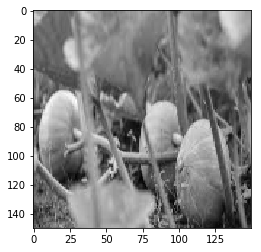

In [26]:
IMG_SIZE = 150 # nous mettons toutes des images à la meme taille 100)

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()


In [27]:
# CREATION DES DONNEES D ENTRAINEMENT 

 
training_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  # créer un chemin vers les categories
        class_num = CATEGORIES.index(category)  # obtenir la classification (0,1 ou 2). 

        for img in tqdm(os.listdir(path)):  # itérer sur chaque image 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convertir en tableau 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # redimentionner pour normaliser la taille des données
                training_data.append([new_array, class_num])  # ajoutez ceci à notre formation_data 
            except Exception as e:  # idans l'intérêt de garder la sortie propre ... 
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 23/23 [00:00<00:00, 493.22it/s]70



In [28]:
import random

random.shuffle(training_data) # melange des donnees 

In [29]:
for sample in training_data[:10]:
    print(sample[1]) # test pour voir si les images ont bien été melangees

0
1
0
0
0
1
1
1
0
2


In [30]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[126]
   [ 99]
   [ 98]
   ...
   [172]
   [120]
   [104]]

  [[127]
   [111]
   [124]
   ...
   [175]
   [164]
   [148]]

  [[120]
   [102]
   [117]
   ...
   [143]
   [155]
   [156]]

  ...

  [[ 44]
   [ 70]
   [ 42]
   ...
   [ 42]
   [ 30]
   [ 20]]

  [[ 63]
   [ 59]
   [ 56]
   ...
   [ 40]
   [ 31]
   [ 26]]

  [[ 75]
   [ 69]
   [113]
   ...
   [ 36]
   [ 31]
   [ 23]]]]


In [31]:
# SAUVEGARDE DES DONNEES 

# on les sauvegarde pour ne pas avoir à les calculer à chaque tour du modèle 

import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()



In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
#from tensorflow.keras.callbacks import TensorBoard
import time

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

dense_layers = [0]
layer_sizes = [64]
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=30000, # nombre de tours
                      validation_split=0.3,
                      callbacks=[tensorboard])

model.save('modellegumes.model')

3-conv-64-nodes-0-dense-1599740999
Train on 49 samples, validate on 21 samples
Epoch 1/30000
49/49 [==============================] - 2s 41ms/sample - loss: 0.6860 - acc: 0.2653 - val_loss: 0.3832 - val_acc: 0.2857
Epoch 2/30000
49/49 [==============================] - 1s 28ms/sample - loss: 0.0998 - acc: 0.3265 - val_loss: 0.6050 - val_acc: 0.2857
Epoch 3/30000
49/49 [==============================] - 1s 27ms/sample - loss: -0.0184 - acc: 0.3265 - val_loss: 1.0564 - val_acc: 0.2857
Epoch 4/30000
49/49 [==============================] - 1s 26ms/sample - loss: -0.4417 - acc: 0.3265 - val_loss: 1.2614 - val_acc: 0.2857
Epoch 5/30000
49/49 [==============================] - 1s 26ms/sample - loss: -0.6473 - acc: 0.3265 - val_loss: 1.5219 - val_acc: 0.2857
Epoch 6/30000
49/49 [==============================] - 1s 26ms/sample - loss: -0.9091 - acc: 0.3265 - val_loss: 2.0832 - val_acc: 0.2857
Epoch 7/30000
49/49 [==============================] - 1s 26ms/sample - loss: -1.3266 - acc: 0.3265 -

KeyboardInterrupt: 